In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC

##### Generate the synthetic data

In [2]:
# Generate synthetic data
np.random.seed(0)
X = np.random.randn(1000, 10)
y = np.random.randint(0, 2, size=1000)  # Binary classification

# Introduce noise
noise_rate = 0.2
y_noisy = y.copy()
n_noisy = int(noise_rate * y.shape[0])
noise_indices = np.random.choice(y.shape[0], n_noisy, replace=False)
y_noisy[noise_indices] = 1 - y_noisy[noise_indices]  # Flip the labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=0.2, random_state=42)

##### Example of a known noise transition matrix T

In [3]:
# Estimate noise transition matrix T
T = np.array([[0.8, 0.2], [0.2, 0.8]])  # Example of a known noise transition matrix

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, T):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        weights[i] = T[y_true[i], y_noisy[i]] / T[y_noisy[i], y_noisy[i]]
    return weights

weights = compute_importance_weights(y_train, y_train_noisy, T)

# Train a classifier with weighted samples
clf = LogisticRegression()
clf.fit(X_train, y_train_noisy, sample_weight=weights)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("MSE of the model:", mean_squared_error(y_test, y_pred))

Accuracy on test set: 0.46
MSE of the model: 0.54


### Estimate T using KDE

In [11]:
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC

# Kernel Density Estimation (KDE)
def estimate_noise_transition_matrix(X, y_noisy, noise_rate):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = kde.score_samples(X) # compute log-density of the data points
    density = np.exp(log_density)
    
    # Estimate transition probabilities
    p_y_given_x = np.mean(density[y_noisy == 1]) / np.mean(density)
    p_not_y_given_x = 1 - p_y_given_x
    
    # Transition matrix (for binary classification)
    T = np.array([[1 - p_not_y_given_x, p_not_y_given_x], 
                  [p_y_given_x, 1 - p_y_given_x]])
    return T

T = estimate_noise_transition_matrix(X_train, y_train_noisy, noise_rate)

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, T):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        true_class = y_true[i]
        noisy_class = y_noisy[i]
        weights[i] = T[true_class, noisy_class] / T[noisy_class, noisy_class]
    return weights

weights = compute_importance_weights(y_train, y_train_noisy, T)

# Train a logistic regression classifier with weighted samples
clf = LogisticRegression()
clf.fit(X_train, y_train_noisy, sample_weight=weights)
# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression with Importance Reweighting Accuracy on test set:", accuracy)

# Train Logistic Regression on noisy data
clf_logistic = LogisticRegression()
clf_logistic.fit(X_train, y_train_noisy)
# Evaluate the classifiers
y_pred_logistic = clf_logistic.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy on clean test set:", accuracy_logistic)

# Train SVM on noisy data
clf_svm = SVC()
clf_svm.fit(X_train, y_train_noisy)
# Evaluate the classifiers
y_pred_svm = clf_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy on clean test set:", accuracy_svm)

Logistic Regression with Importance Reweighting Accuracy on test set: 0.48
Logistic Regression Accuracy on clean test set: 0.48
SVM Accuracy on clean test set: 0.545


### Importance weighted logistic loss with estimated noise rates
Kernel Logistic-Loss-Based Method

In [10]:
# Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = kde.score_samples(X)
    density = np.exp(log_density)
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    rho_plus_1 = np.min(p_y0_given_x) # flipped from -1 to +1
    rho_minus_1 = np.min(p_y1_given_x) # flipped from +1 to -1
    
    return rho_minus_1, rho_plus_1

rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1 # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1 # the likelihood that a sample labeled as -1 is indeed a true negative
    return weights

weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)

# Train a logistic regression classifier with weighted samples
clf = LogisticRegression()
clf.fit(X_train, y_train_noisy, sample_weight=weights)
# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Kernel Logistic Regression with Importance Reweighting Accuracy on test set:", accuracy)

# Train Logistic Regression on noisy data
clf_logistic = LogisticRegression()
clf_logistic.fit(X_train, y_train_noisy)
# Evaluate the classifiers
y_pred_logistic = clf_logistic.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy on clean test set:", accuracy_logistic)

# Train SVM on noisy data
clf_svm = SVC()
clf_svm.fit(X_train, y_train_noisy)
# Evaluate the classifiers
y_pred_svm = clf_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy on clean test set:", accuracy_svm)

Kernel Logistic Regression with Importance Reweighting Accuracy on test set: 0.475
Logistic Regression Accuracy on clean test set: 0.48
SVM Accuracy on clean test set: 0.545


Mean accuracy of reweighted logistic regression: 0.5019
Mean accuracy of logistic regression: 0.4995
Mean accuracy of SVM: 0.5005


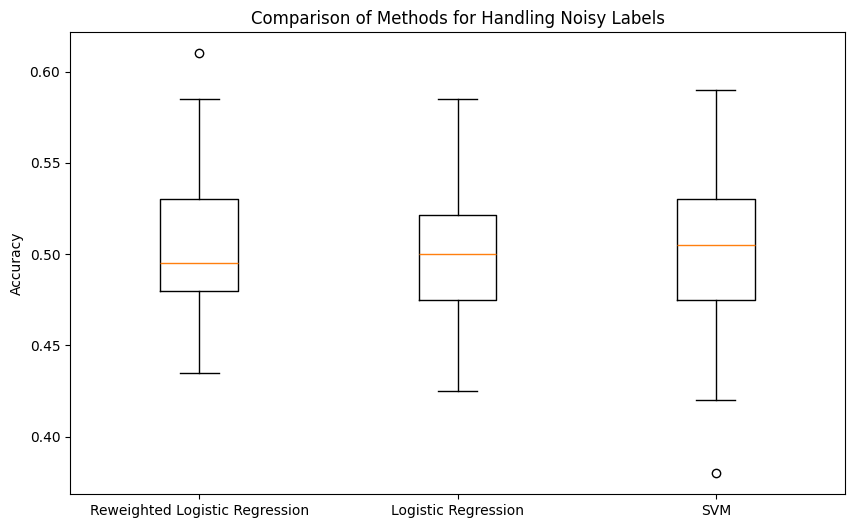

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Fix a Simulation Distribution
def generate_data(n_samples=1000, n_features=10, noise_rate=0.2):
    X = np.random.randn(n_samples, n_features)
    y = np.random.randint(0, 2, size=n_samples)
    y_noisy = y.copy()
    n_noisy = int(noise_rate * y.shape[0])
    noise_indices = np.random.choice(y.shape[0], n_noisy, replace=False)
    y_noisy[noise_indices] = 1 - y_noisy[noise_indices]
    return X, y, y_noisy

# Produce "Infinitely Many" Independent and Identically Distributed Datasets
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = kde.score_samples(X)
    density = np.exp(log_density)
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    
    return rho_minus_1, rho_plus_1

def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

def apply_methods(X_train, y_train_noisy, X_test, y_test):
    rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
    weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)

    # Train logistic regression with reweighting
    clf_reweighted = LogisticRegression()
    clf_reweighted.fit(X_train, y_train_noisy, sample_weight=weights)
    y_pred_reweighted = clf_reweighted.predict(X_test)
    accuracy_reweighted = accuracy_score(y_test, y_pred_reweighted)

    # Train logistic regression without reweighting
    clf_logistic = LogisticRegression()
    clf_logistic.fit(X_train, y_train_noisy)
    y_pred_logistic = clf_logistic.predict(X_test)
    accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

    # Train SVM without reweighting
    clf_svm = SVC()
    clf_svm.fit(X_train, y_train_noisy)
    y_pred_svm = clf_svm.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)

    return accuracy_reweighted, accuracy_logistic, accuracy_svm

# Apply the Methods to Each Dataset and analyze the "Second Level Dataset"
n_simulations = 100
n_samples = 1000
n_features = 10
noise_rate = 0.2

accuracies_reweighted = []
accuracies_logistic = []
accuracies_svm = []

for _ in range(n_simulations):
    X, y, y_noisy = generate_data(n_samples=n_samples, n_features=n_features, noise_rate=noise_rate)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=0.2, random_state=42)

    acc_reweighted, acc_logistic, acc_svm = apply_methods(X_train, y_train_noisy, X_test, y_test)
    accuracies_reweighted.append(acc_reweighted)
    accuracies_logistic.append(acc_logistic)
    accuracies_svm.append(acc_svm)

# Compare the Results with the Ground Truth
print(f"Mean accuracy of reweighted logistic regression: {np.mean(accuracies_reweighted):.4f}")
print(f"Mean accuracy of logistic regression: {np.mean(accuracies_logistic):.4f}")
print(f"Mean accuracy of SVM: {np.mean(accuracies_svm):.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.boxplot([accuracies_reweighted, accuracies_logistic, accuracies_svm], labels=['Reweighted Logistic Regression', 'Logistic Regression', 'SVM'])
plt.ylabel('Accuracy')
plt.title('Comparison of Methods for Handling Noisy Labels')
plt.show()

Linear Logistic-Loss-Based

In [4]:
# Estimate noise rates directly (here using simple proportion of flipped labels)
rho_plus_1 = np.sum(y_train_noisy[y_train == 0] == 1) / np.sum(y_train == 0)
rho_minus_1 = np.sum(y_train_noisy[y_train == 1] == 0) / np.sum(y_train == 1)

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 (here interpreted as -1) is indeed a true negative
    return weights

weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)

# Train a logistic regression classifier with weighted samples
clf = LogisticRegression()
clf.fit(X_train, y_train_noisy, sample_weight=weights)

# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Linear Logistic Regression with Importance Reweighting Accuracy on test set:", accuracy)

Linear Logistic Regression with Importance Reweighting Accuracy on test set: 0.495


### Example of KDE and asymmetric noise

In [6]:
# Regenerate synthetic data
np.random.seed(0)
X = np.random.randn(1000, 10)
y = np.random.randint(0, 2, size=1000)  # Binary classification

# Introduce asymmetric noise
asym_noise_rate_0_to_1 = 0.1  # Noise rate for class 0 flipped to class 1
asym_noise_rate_1_to_0 = 0.3  # Noise rate for class 1 flipped to class 0
y_noisy = y.copy()

# Flip labels from 0 to 1 with probability asym_noise_rate_0_to_1
indices_0_to_1 = np.where(y == 0)[0]
flip_indices_0_to_1 = np.random.choice(indices_0_to_1, int(asym_noise_rate_0_to_1 * len(indices_0_to_1)), replace=False)
y_noisy[flip_indices_0_to_1] = 1

# Flip labels from 1 to 0 with probability asym_noise_rate_1_to_0
indices_1_to_0 = np.where(y == 1)[0]
flip_indices_1_to_0 = np.random.choice(indices_1_to_0, int(asym_noise_rate_1_to_0 * len(indices_1_to_0)), replace=False)
y_noisy[flip_indices_1_to_0] = 0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=0.2, random_state=42)

In [7]:
# Kernel Density Estimation (KDE)
def estimate_noise_transition_matrix(X, y_noisy, noise_rate):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = kde.score_samples(X) # compute log-density of the data points
    density = np.exp(log_density)
    
    # Estimate transition probabilities
    p_y_given_x = np.mean(density[y_noisy == 1]) / np.mean(density)
    p_not_y_given_x = 1 - p_y_given_x
    
    # Transition matrix (for binary classification)
    T = np.array([[1 - p_not_y_given_x, p_not_y_given_x], 
                  [p_y_given_x, 1 - p_y_given_x]])
    return T

T = estimate_noise_transition_matrix(X_train, y_train_noisy, noise_rate)

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, T):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        true_class = y_true[i]
        noisy_class = y_noisy[i]
        weights[i] = T[true_class, noisy_class] / T[noisy_class, noisy_class]
    return weights

weights = compute_importance_weights(y_train, y_train_noisy, T)

# Train a logistic regression classifier with weighted samples
clf = LogisticRegression()
clf.fit(X_train, y_train_noisy, sample_weight=weights)
# Evaluate the classifier
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression with Importance Reweighting Accuracy on test set:", accuracy)

# Train Logistic Regression on noisy data
clf_logistic = LogisticRegression()
clf_logistic.fit(X_train, y_train_noisy)
# Evaluate the classifiers
y_pred_logistic = clf_logistic.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Accuracy on clean test set with asymmetric noise:", accuracy_logistic)

# Train SVM on noisy data
clf_svm = SVC()
clf_svm.fit(X_train, y_train_noisy)
y_pred_svm = clf_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy on clean test set with asymmetric noise:", accuracy_svm)

Logistic Regression with Importance Reweighting Accuracy on test set: 0.51
Logistic Regression Accuracy on clean test set with asymmetric noise: 0.51
SVM Accuracy on clean test set with asymmetric noise: 0.51
